In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# IMPORT DATA
- **comments.csv** Contains raw patient comments.
- **efftreat.csv** Contains scores for treatment (0 = irrelevant, 1 = worst, 5 = best)


In [3]:
# Import data & merge comments and treatment scores
df_comments = pd.read_csv("comments.csv")
df_treatment = pd.read_csv("efftreat.csv")
df = pd.merge(df_comments, df_treatment, how="inner")

# 643 blank comments (those rows remove)
df = df.dropna(axis = 0)

# 9357 samples to work with
print(f'Number of rows {len(df)}')

df.head(5)

Number of rows 9357


,id,comment,efftreat
0,5876,I was told I wasnt allowed in with my house ma...,1.0
1,6555,Imagine telling a Rheumatoid Arthritis suffere...,1.0
2,1448,"Not exactly loved, but good to go when it's re...",4.0
3,3351,Shower facilities had a clear plastic bag of w...,0.0
4,231,Is worst place what I seen in my life. 8h wait...,4.0


In [4]:
# Very imbalanced dataset. Not many 1/2/3 (makes sense to map to binaries)
df["efftreat"].value_counts()

5.0    4289
0.0    3019
4.0    1021
1.0     546
2.0     430
3.0      52
Name: efftreat, dtype: int64

In [5]:
# Replace all values >0 with 0.
df["efftreat"].replace({1:1, 2:1, 3:1, 4:1, 5:1}, inplace=True)
df.head(5)

,id,comment,efftreat
0,5876,I was told I wasnt allowed in with my house ma...,1.0
1,6555,Imagine telling a Rheumatoid Arthritis suffere...,1.0
2,1448,"Not exactly loved, but good to go when it's re...",1.0
3,3351,Shower facilities had a clear plastic bag of w...,0.0
4,231,Is worst place what I seen in my life. 8h wait...,1.0


In [6]:
# Still imbalanced
class_weights = dict(df["efftreat"].value_counts())
class_weights

{1.0: 6338, 0.0: 3019}

# Preprocess Data

In [7]:
# Replace # and @ which are appear frequently at beginning of some words
df["comment"] = df["comment"].map(lambda x: x.replace("#", ""))
df["comment"] = df["comment"].map(lambda x: x.replace("@", ""))

# Focus on words, i.e. remove numbers and punctuation
def words_only(x):
    return " ".join(re.findall(r"[\w']+", x))
df["comment"] = df["comment"].apply(words_only)

In [8]:
# Tokenize text (punctuation removed by default, words moved to lower case, all words kept in this case)
sentences = list(df["comment"])
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True, split = ' ')
tokenizer.fit_on_texts(sentences)

vocab_size = len(tokenizer.word_counts)
print(f'vocab_size {vocab_size}')

word2idx = tokenizer.word_index
idx2word = {v:k for (k,v) in word2idx.items()}

vocab_size 16893


In [9]:
# To save computations I am going to truncate after 100 words (c. 90% + won't be affected)
seq_lengths = np.array([len(s.split()) for s in sentences])
print([(p, np.percentile(seq_lengths, p)) for p in [75, 80, 90, 95, 99, 100]])
max_seqlen = 100

[(75, 56.0), (80, 68.0), (90, 113.0), (95, 163.0), (99, 328.4400000000005), (100, 1384.0)]


# Prepare Dataset

In [10]:
# Vectorize sentences by turning words -> unique integers
sentences_as_ints = tokenizer.texts_to_sequences(sentences)
sentences_as_ints = tf.keras.preprocessing.sequence.pad_sequences(sentences_as_ints, maxlen=max_seqlen, padding='post')
label_as_ints = np.array(df["efftreat"])

print(f'Example sentence before: {sentences[5]}')
print(f'Example sentence after: {sentences_as_ints[5]}')

Example sentence before: Your whole walk in treatment process was faultless as was the treatment
Example sentence after: [ 101  269  431    8   64  382    6 1608   32    6    1   64    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [11]:
# Create a tensorflow dataset out of the data / labels (allows for transformations / iteration)
dataset = tf.data.Dataset.from_tensor_slices((sentences_as_ints, label_as_ints))

# Train / Test / Split

In [12]:
# Shuffle dataset, split into c. 80%, 10%, 10%.
dataset = dataset.shuffle(10000)
test_size = round(len(sentences)*0.10)
val_size = round(len(sentences)*0.10)
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)
print(f'train: {train_dataset.cardinality()}, val: {val_dataset.cardinality()}, test: {test_dataset.cardinality()}')

train: 7485, val: 936, test: 936


In [13]:
# Batch dataset for faster training
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Model Build / Training

In [14]:
# Bidrectional LSTM
class TreatmentClassifier(tf.keras.Model):
    def __init__(self, vocab_size, max_seqlen, **kwargs):
        super(TreatmentClassifier, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, max_seqlen)
        self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(max_seqlen))
        self.dense = tf.keras.layers.Dense(100, activation = 'relu')
        self.out = tf.keras.layers.Dense(1, activation = 'sigmoid')

    def call(self, x):
        x = self.embedding(x)
        x = self.bilstm(x)
        x = self.dense(x)
        x = self.out(x)
        return x

In [15]:
model = TreatmentClassifier(vocab_size+1, max_seqlen)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()

Model: "treatment_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1689400   
_________________________________________________________________
bidirectional (Bidirectional multiple                  160800    
_________________________________________________________________
dense (Dense)                multiple                  20100     
_________________________________________________________________
dense_1 (Dense)              multiple                  101       
Total params: 1,870,401
Trainable params: 1,870,401
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Save best model, set up call backs
data_dir = "./data"
logs_dir = os.path.join("./logs")
best_model_file = os.path.join(data_dir, "best_model_treat.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_file, save_weights_only=True, save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [32]:
# Number epochs = 10 (train on data 10 times), passing through 117 batches (of 64). Add class weights. Add callbacks.
num_epochs = 10
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset, class_weight = class_weights, callbacks=[checkpoint, tensorboard])

Epoch 1/10
117/117 [==============================] - 63s 542ms/step - loss: 357.2960 - accuracy: 0.9667 - val_loss: 0.0391 - val_accuracy: 0.9850
Epoch 2/10
117/117 [==============================] - 48s 407ms/step - loss: 272.9913 - accuracy: 0.9749 - val_loss: 0.0468 - val_accuracy: 0.9893
Epoch 3/10
117/117 [==============================] - 49s 422ms/step - loss: 214.5204 - accuracy: 0.9818 - val_loss: 0.0626 - val_accuracy: 0.9765
Epoch 4/10
117/117 [==============================] - 47s 401ms/step - loss: 215.3271 - accuracy: 0.9818 - val_loss: 0.0413 - val_accuracy: 0.9861
Epoch 5/10
117/117 [==============================] - 48s 413ms/step - loss: 174.9560 - accuracy: 0.9858 - val_loss: 0.0486 - val_accuracy: 0.9840
Epoch 6/10
117/117 [==============================] - 50s 427ms/step - loss: 163.4218 - accuracy: 0.9865 - val_loss: 0.0355 - val_accuracy: 0.9893
Epoch 7/10
117/117 [==============================] - 49s 423ms/step - loss: 153.5689 - accuracy: 0.9865 - val_loss: 0

# Model Analysis

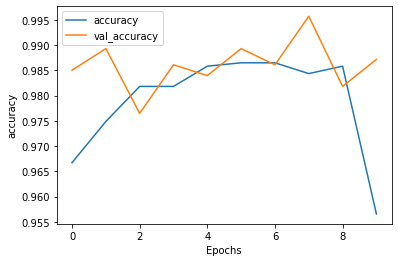

In [37]:
# Plot History and BCE loss. Nice training profile. High train and validation accuracy.
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "val_accuracy"])
plt.show()


In [18]:
# Download best model from each epoch (vs. validation data)
best_model = TreatmentClassifier(vocab_size+1, max_seqlen)
best_model.build(input_shape=(batch_size, max_seqlen))
best_model.load_weights(best_model_file)
best_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
# Test data performance....98.4% accuracy
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f'test accuracy: {test_acc}, test_loss: {test_loss}')

15/15 [==============================] - 1s 63ms/step - loss: 0.0221 - accuracy: 0.9968
test accuracy: 0.9967948794364929, test_loss: 0.022122660651803017


In [39]:
# Confusion Matrix. 
preds = []
labels = []
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = best_model.predict(inputs_b)
    preds.extend([1 if p > 0.5 else 0] for p in pred_batch)
    labels.extend([l.numpy() for l in labels_b])

false_pos = []
false_neg = []
for i in range(len(labels)):
    if preds[i] != labels[i]:
        if preds[i] == [1] and labels[i] == 0:
            false_pos.append(i)
        if preds[i] == [0] and labels[i] == 1:
            false_neg.append(i)

print(f'CONFUSION MATRIX')
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, preds)

CONFUSION MATRIX


array([[285,  10],
       [  5, 636]], dtype=int64)

In [52]:
# Look at false positives
false_pos_vectors = []
counter = 0
for x in test_dataset.unbatch():
    if counter in false_pos:
        inputs_b, labels_b = x
        false_pos_vectors.append(inputs_b)
    counter += 1

print(f'false positive indices: {false_pos}')

for vector in false_pos_vectors:
    print("-----")
    print(" ".join([idx2word[i] for i in list(vector.numpy()) if i !=0]))

false positive indices: [344, 437, 440, 499, 543, 547, 619, 797, 855, 861]
-----
had to resort to coming to a e due to no available gp appointments for 2 days and i needed antibiotics asap a e staff were friendly and i was seen quickly then referred to the urgent care ward to see a helpful doctor the woman on reception at the urgent care ward this afternoon was not nice very patronising passive aggressive and seemingly irritated that anyone was even using the hospital unfortunately if people are sick and need medical attention but there are no gp appointments available they will need to use the hospital facilities
-----
amazing it really is please pass on my thanks to the staff who dealt with me they were amazing so professional showed excellent compassion in their individual practice and reassured me as i was in shock and rather hysterical thinking i was paralysed i really can't thank them enough i had a ct and it was clear thank the lord so i am just taking it easy and when i ski aga

In [53]:
# Look at false negatives
false_neg_vectors = []
counter = 0
for x in test_dataset.unbatch():
    if counter in false_neg:
        inputs_b, labels_b = x
        false_neg_vectors.append(inputs_b)
    counter += 1

print(f'false negative indices: {false_neg}')

for vector in false_neg_vectors:
    print("-----")
    print(" ".join([idx2word[i] for i in list(vector.numpy()) if i !=0]))

false negative indices: [76, 93, 146, 237, 661]
-----
the two a e consultants i saw masooma rizvi and dominic harrison were both very efficient professional helpful and kind top marks there whilst the covid 19 check on entry is understandable it adds an extra layer to registration that is inefficient there is 1 covid 19 2 general reception 3 triage and some details provided 3 times and much more than just confirming id i have some understanding of queuing theory you could cut down your waiting times considerably and report a better performance by some considered thought on this process with relevant details other than confirming id jus
-----
thank to all of the newborn feeding team on castle acre ward and the frenulotomy team you gave me time and a listening ear but most importantly you gave me the support we needed to continue with breast feeding an amazing valuable team
-----
paediatric surgery woweeeee thank you nhs brilliant from beginning to end every single member of staff was he